# Flappy Birds Q-learning

Dieses Notebook dient der Demonstration des klassischen Q-learning Algorithmus am Beispiel einer eigenen Implementierung des bekannten Handyspiels Flappy Birds.

### Imports und Parameter

In [3]:
import random
import time
import copy

import tkinter as tk
import numpy as np
import matplotlib.animation as animation

from collections import defaultdict
from IPython.display import HTML
from matplotlib import pyplot as plt

Grafikeinstellungen. _spacing_ bestimmt Anzahl zusätzlicher nichtgenutzter Pixel. _scale_ ist der Skalierungsfaktor.

In [4]:
spacingX = 5
spacingY = 5

scale = 15

Größe des state-Raums festlegen:

In [30]:
sizeX = 20
sizeY = 30
sizeG = 6
sizeP = 3

### Spiel und MDP Logik definieren

In [5]:
class Game:
    """ Toplevel class managing the actual game. """
    def __init__(self, Q=None):
        self.sizeX = sizeX
        self.sizeY = sizeY
        self.sizeG = sizeG
        self.sizeP = sizeP
        
        self.state = (self.sizeY//2, self.sizeX-1, (self.sizeY+self.sizeG)//2, 3)
        self.next_state = None
        self.action = None
        self.reward = None
        
        self.t = 0
        self.am_passed = 0

        self.diffs = [-2, -1, 1, 2]  # amount of 'pixels' birds moves up/down in one time-step
        self.tick = 2  # tick operates on diffs. tick=2 means diff of 1
        
        if Q:
            self.Q = Q
        
    def environment(self):
        """Calculates the next state and reward given the actual state and action-choice."""
        self.tick = min(self.tick+1, 3)
        
        if self.action == "jump":
            self.tick = 0
        birdY = max(self.state[0]+self.diffs[self.tick], 0)  # bird gets bounded by upper screen end
        self.next_state = (birdY, self.state[1]-1, self.state[2], self.tick)
        
        if self.collision():
            self.next_state = "dead"
            self.reward = -1
            
        elif self.next_state[1]+self.sizeP == 0:
            self.next_state = "goal"
            self.reward = 1
        
        else:
            self.reward = 0
    
    
    def collision(self):
        """Checks whether bird collided with pipe or bottom."""
        if self.next_state[0] >= self.sizeY:  # collision with bottom
            return True
        if self.next_state[1] <= 0 and self.next_state[1]+self.sizeP-1>=0:  # collision with pipe
            if self.next_state[0] >= self.next_state[2] or self.next_state[0] < self.next_state[2]-self.sizeG:
                return True
        return False
    
    def time_step(self):
        """Executes one time-step, consisting of action-choice by policy, environmental reaction and Q-Update."""
        self.t += 1
        
        self.policy()
        self.environment()
        
        if self.next_state not in ["dead", "goal"]:
            self.state = self.next_state
        else:
            self.state = (random.randrange(self.sizeY), self.sizeX-1, random.randrange(self.sizeG, self.sizeY), random.randrange(6))
    
    
    def episode(self):
        """Plays one episode (until bird collides)."""
        while self.next_state != "dead":
            self.time_step()
            if self.next_state == "goal":
                self.am_passed += 1
                if self.am_passed % 1e2 == 0:
                    print(self.am_passed)
                    
    def policy(self):  # µ
        """Epsilon-greedy policy w.r.t. Q."""
        
        if self.Q[self.state]["jump"] > self.Q[self.state]["wait"]:
            self.action = "jump"
        else:
            self.action = "wait"

In [6]:
class EvalGame(Game):
    """ Sublevel class used for running evaluation games. """
    def __init__(self, Q, runs=1e3):
        super().__init__()
        
        self.Q = Q.copy()
        self.runs = runs
        self.values = []
        
        self.mean = None
        self.var = None
        self.max = None
        self.min = None
        
        self.dead_states = set()
        self.dead_state_ratio = None
    
    
    def evaluate(self):
        """ Evaluate performance. """
        st = time.time()
        for r in range(int(self.runs)):
            g = Game(self.Q)
            g.episode()
            self.values.append(g.am_passed)
            if time.time() - st > 10:
                print(f"Eval-Abbruch nach {r} runs.")
                break
        
        self.mean = np.mean(self.values)
        self.var = np.var(self.values)
        self.max = np.max(self.values)
        self.min = np.min(self.values)
    
    def check_all_states(self):
        """ Check whether all states were visitied and check their expected outcome. """
        count = 0
        for l in range(len(self.diffs)):
            for k in range(5, self.sizeY - self.sizeG):
                for j in range(1, self.sizeX):
                    for i in range(min(0, (k+self.sizeG) - 2*j), max(self.sizeY-self.sizeG, (k-1)+2*j)):
                        count += 1
                        state = (i, j, k, l)
                        self.state = (i, j, k, l)
                        self.next_state = None
                        while self.next_state not in ["dead", "goal"]:
                            self.time_step()
                        if self.next_state == "dead":
                            self.dead_states.add(state)
                for j in range(-2, 1):
                    for i in range(k-self.sizeG, k):
                        count += 1
                        state = (i, j, k, l)
                        self.state = (i, j, k, l)
                        self.next_state = None
                        while self.next_state not in ["dead", "goal"]:
                            self.time_step()
                        if self.next_state == "dead":
                            self.dead_states.add(state)
        self.dead_state_ratio = len(self.dead_states) / count
        print(len(self.dead_states), count)

In [60]:
class TrainGame(Game):
    """ Sublevel class used for running training games. """
    def __init__(self, gamma, Q_start=None, runs=1e3):
        super().__init__()
        
        # Q-learning Stuff:
        self.Q = defaultdict(lambda: defaultdict(lambda: 0))
        self.N = defaultdict(lambda: defaultdict(lambda: 0))
        if Q_start:
            self.Q = Q
        self.epsilon = 1
        
        # Hyperparameters
        self.gamma = gamma
        
        # Evaluation Stuff:
        self.runs = runs  # amount of games played in each evaluation session
        self.eval_steps = []
        self.eval_mean = []
        self.eval_var = []
        self.eval_max = []
        self.eval_min = []
        self.check_dead_states_ratios = []
        
        # Visualization Stuff
        self.pics = []


    def policy(self):  # µ
        """Epsilon-greedy policy w.r.t. Q."""
        self.epsilon = 1 / (self.N[self.state][self.action] + 1)  # epsilon = 1 / (#times the state-action-pair got visited)
        
        # exploratory choice:
        if (np.random.uniform(0, 1) < self.epsilon) or (self.Q[self.state]["jump"]==self.Q[self.state]["wait"]):
            self.action = random.choice(["jump", "wait"])
        # greedy choice:    
        elif self.Q[self.state]["jump"] > self.Q[self.state]["wait"]:
            self.action = "jump"
        else:
            self.action = "wait"
    
    def q_update(self):
        """Performs update of the Q-Values."""
        state, action, next_state, reward, gamma = self.state, self.action, self.next_state, self.reward, self.gamma
        alpha = 1/(self.N[state][action]+1)  # satisfies Robbins-Monroe conditions
        old = self.Q[state][action]
        
        self.Q[state][action] = old + alpha * (reward + gamma * max(self.Q[next_state]["jump"], self.Q[next_state]["wait"]) - old) 

    def time_step(self):
        """Executes one time-step, consisting of action-choice by policy, environmental reaction and Q-Update."""
        self.t += 1
        self.N[self.state][self.action] += 1
        
        self.policy()
        self.environment()
        self.q_update()
        
        if self.next_state not in ["dead", "goal"]:
            self.state = self.next_state
        else:
            self.state = (random.randrange(self.sizeY), self.sizeX-1, random.randrange(self.sizeG, self.sizeY), random.randrange(6))
    
    def train(self, max_steps=1e6):
        """Trains by performing max_steps timesteps."""
        start_time = time.time()
        
        while self.t <= max_steps:
            
            self.time_step()
            
            # for visualization:
            if self.t % int(max_steps/1e1) == 0 or self.t in [0,1,10,100,1e3,1e4,1e5,1e6,1e7,1e8]:
                pic = np.zeros((self.sizeY, self.sizeX))
                Q_copy = copy.deepcopy(self.Q)
                for row in range(self.sizeY):
                    for col in range(self.sizeX):
                        state = (row, col, 11, 3)
                        pic[row][self.sizeX-1 - col] += float(Q_copy[state]["jump"] - Q_copy[state]["wait"])
                if pic.max() != 0 or pic.min() != 0:
                    pic = (pic - pic.min())/(pic.max() - pic.min())  #MinMax Scaler
                self.pics.append(pic)
    
            # for evaluation during training:
            if self.t % int(max_steps/1e1) == 0 or self.t in [0,1,10,100,1e3,1e4,1e5,1e6,1e7,1e8]:
                print("Evaluation beginnt.", end="")
                e = EvalGame(Q_copy, self.runs)
                e.evaluate()
                
                print("Abgeschlossen.", end="\n")
                self.eval_steps.append(self.t)
                self.eval_mean.append(e.mean)
                self.eval_var.append(e.var)
                self.eval_max.append(e.max)
                self.eval_min.append(e.min)
                print(f"t: {self.t}; besucht: {len(self.Q)} ({round(100* len(self.Q)/((self.sizeX+self.sizeP-1)*self.sizeY*(self.sizeY-self.sizeG)*len(self.diffs)))}%); mean: {round(e.mean, 3)}; var: {round(e.var, 3)}; max: {round(e.max, 3)}; min: {round(e.min, 3)};") # dead-ratio: {round(e.dead_state_ratio, 3)}")

        print(f"Training beendet. {max_steps} timesteps in {time.time()-start_time} Sekunden.")
    
    def plot(self):
        figure, axis = plt.subplots(2, 2)
        figure.tight_layout()

        axis[0, 0].plot(self.eval_steps, self.eval_mean)
        axis[0, 0].set_title("Mittelwert")

        axis[1, 0].plot(self.eval_steps, self.eval_var)
        axis[1, 0].set_title("Varianz")

        axis[0, 1].plot(self.eval_steps, self.eval_max)
        axis[0, 1].set_title("Max")

        axis[1, 1].plot(self.eval_steps, self.eval_min)
        axis[1, 1].set_title("Min")

In [8]:
class ErrorStatesGame(TrainGame):
    """ Sublevel class used for finding error states. """
    def __init__(self, error_states=None, Q=None):
        super().__init__()
        
        self.error_states = error_states
        self.am_error_states = len(error_states)
        self.Q = Q
    
    def time_step(self):
        self.t += 1
        self.N[self.state][self.action] += 1
        
        self.policy()
        self.environment()
        self.q_update()
        
        if self.next_state not in ["dead", "goal"]:
            self.state = self.next_state
        else:
            self.state = self.error_states[self.t % self.am_error_states]

## Training

In [61]:
game = TrainGame(gamma=0.9)

In [62]:
game.train(1e6)

Evaluation beginnt.Abgeschlossen.
t: 1; besucht: 2 (0%); mean: 0.0; var: 0.0; max: 0; min: 0;
Evaluation beginnt.Abgeschlossen.
t: 10; besucht: 11 (0%); mean: 0.0; var: 0.0; max: 0; min: 0;
Evaluation beginnt.Abgeschlossen.
t: 100; besucht: 102 (0%); mean: 0.0; var: 0.0; max: 0; min: 0;
Evaluation beginnt.Abgeschlossen.
t: 1000; besucht: 974 (2%); mean: 0.0; var: 0.0; max: 0; min: 0;
Evaluation beginnt.Abgeschlossen.
t: 10000; besucht: 7419 (12%); mean: 0.0; var: 0.0; max: 0; min: 0;
Evaluation beginnt.Abgeschlossen.
t: 100000; besucht: 33059 (52%); mean: 0.0; var: 0.0; max: 0; min: 0;
Evaluation beginnt.Abgeschlossen.
t: 200000; besucht: 41857 (66%); mean: 0.0; var: 0.0; max: 0; min: 0;
Evaluation beginnt.Abgeschlossen.
t: 300000; besucht: 45361 (72%); mean: 0.0; var: 0.0; max: 0; min: 0;
Evaluation beginnt.Abgeschlossen.
t: 400000; besucht: 46988 (74%); mean: 1.723; var: 1.166; max: 11; min: 1;
Evaluation beginnt.Abgeschlossen.
t: 500000; besucht: 47932 (76%); mean: 2.269; var: 2.639

Mittelwert/mean: durchschnittlich überwundene Hindernisse (in _runs_ durchgängen)<br />
Max: maximale Anzahl an in einem Spiel überwundenen Hindernissen (in _runs_ durchgängen)<br />
Min: minimale Anzahl an in einem Spiel überwundenen Hindernissen (in _runs_ durchgängen)

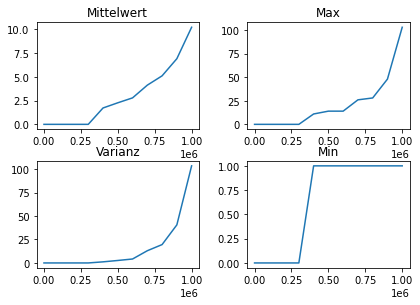

In [63]:
game.plot()

Visualisierung mehrer states im Verlauf des Trainings.<br />
Dunkelblaues Pixel: die Aktion "fallen lassen" wird bevorzugt, d.h. self.Q[self.state]["jump"] < self.Q[self.state]["wait"]<br />
Gelbes Pixel: die Aktion "springen" wird bevorzugt, d.h. self.Q[self.state]["jump"] > self.Q[self.state]["wait"]<br />
Die Farbintensität der Pixel ist proportional zum Q-Wert der Aktion.

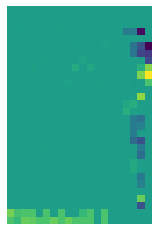

In [64]:
video(game.pics)

## Visualisierung

In [66]:
class VisGame(Game):
    """ Sublevel class used for visualising games. """
    def __init__(self, Q):
        super().__init__()
        self.Q = Q
        
        self.birdView = None
        self.pipeLowView = None
        self.pipeTopView = None
        self.old_state = None
        self.redboxView = None
        self.dead = False
        
        self.root = tk.Tk()
        self.canvas = tk.Canvas(width=(self.sizeX+spacingX)*scale, height=(self.sizeY+spacingY)*scale, background="green")
    
        self.sample_states = []
        
    def draw(self):
        self.canvas.delete(self.birdView, self.pipeLowView, self.pipeTopView, self.redboxView)
        state = self.state
        
        self.birdView = self.canvas.create_rectangle(
            spacingX*scale,
            state[0]*scale,
            (spacingX+1)*scale,
            (state[0]+1)*scale,
        )
        self.pipeLowView = self.canvas.create_rectangle(
            (spacingX+state[1])*scale,
            state[2]*scale,
            (spacingX+state[1]+self.sizeP)*scale,
            (spacingY+self.sizeY)*scale
        )
        self.pipeTopView = self.canvas.create_rectangle(
            (spacingX+state[1])*scale,
            0,
            (spacingX+state[1]+self.sizeP)*scale,
            (state[2]-self.sizeG)*scale
        )
        self.root.update()

    def pi(self):
        if self.Q[self.state]["jump"] > self.Q[self.state]["wait"]:
            self.action = "jump"
        else:
            self.action = "wait"
    
    def time_step(self):
        self.dead = False
        
        self.pi()
        self.environment()
        if self.next_state not in ["dead", "goal"]:
            self.state = self.next_state
        elif self.next_state == "dead":
            print("DEAD")
            self.dead = True
        else:
            self.state = (self.state[0], self.sizeX-1, random.randrange(self.sizeG, self.sizeY), self.tick)
    
    
    def play(self):
        self.canvas.pack()
        while True:
            self.sample_states.append(self.state)
            self.time_step()
            if self.dead:
                self.redboxView = self.canvas.create_rectangle(0,0,self.sizeX*scale, scale, fill="red")
                self.root.update()
                time.sleep(2)
                self.state = (self.sizeY//2, self.sizeX-1, (self.sizeY+self.sizeG)//2, 3)
            self.draw()
            time.sleep(0.1)  # seconds between each frame

    def vis_state(self, posY, tick):
        pic = np.zeros((self.sizeY, self.sizeX))
        for row in range(self.sizeY):
            for col in range(self.sizeX):
                state = (row, col, posY, tick)
                pic[row][col] += float(self.Q[state]["jump"] - self.Q[state]["wait"])
        pic = (pic - pic.min())/(pic.max() - pic.min())  #MinMax Scaler
        return pic

In [38]:
def video(S):
    """Turn list of images into interactive animation.

    Args:
        S (list): List of  consecutive frames to plot.

    Returns:
        html.animation: Iteractive animation.
    """
    fig, ax = plt.subplots()
    ims = []
    for s in S:
        im = ax.imshow(s, animated=True)
        ax.axis('off')
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,repeat_delay=5000)
    return HTML(ani.to_jshtml())

### Spiel ausführen und darstellen

In [67]:
vis_game = VisGame(game.Q)
vis_game.play()

TclError: invalid command name ".!canvas"

### Double Q-learning

In [ ]:
class DoubleQTrainGame(TrainGame):
    """ Sublevel class used for training games using the double-q-learning approach. """
    def __init__(self, gamma, Q1=None, Q2=None):
        super().__init__(gamma)
        
        # Q-learning Stuff:
        self.Q1 = defaultdict(lambda: defaultdict(lambda: 0))
        self.Q2 = defaultdict(lambda: defaultdict(lambda: 0))
        
        if Q1:
            self.Q1 = Q1
        if Q2:                                           
            self.Q2 = Q2
    
    def q_update(self):
        """Modified Q-learning Update."""
        state, action, next_state, reward, gamma = self.state, self.action, self.next_state, self.reward, self.gamma
        alpha = 1/(self.N[state][action]+1)
        if np.random.uniform(0, 1) < 0.5:
            old = self.Q1[state][action]

            self.Q1[state][action] = old + alpha * (reward + gamma * max(self.Q2[next_state]["jump"], self.Q1[next_state]["wait"]) - old) 
        else:
            old = self.Q2[state][action]

            self.Q2[state][action] = old + alpha * (reward + gamma * max(self.Q1[next_state]["jump"], self.Q2[next_state]["wait"]) - old) 